Predict the atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory in Hawaii.

In [1]:
# Import the necessary libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Import the dataset
dataframe = sm.datasets.co2.load_pandas()


# From the imported data, select the part that is under the name "data"
df = dataframe.data

Notice that the data set is given per week. To make things simpler we can sample the data and have an average measurement for each month. This can be done by using the resample() function. Note that using the option resample('MS'), the 'MS' string, groups the data in bins starting at the first of each month.

In [3]:
df = df['co2'].resample('MS').mean()
 
# Have a look on the dataset
print(df.head())

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64


In [4]:
# As you see the measurement for June 1958 is missing. Let's see how many values are missing totally.
print(df.isnull().sum())

5


In [5]:
# Since we dont want to remove the missing values, as an assumption, we may fill the missing values, with the value of 
# the previous month.
df = df.fillna(df.bfill())

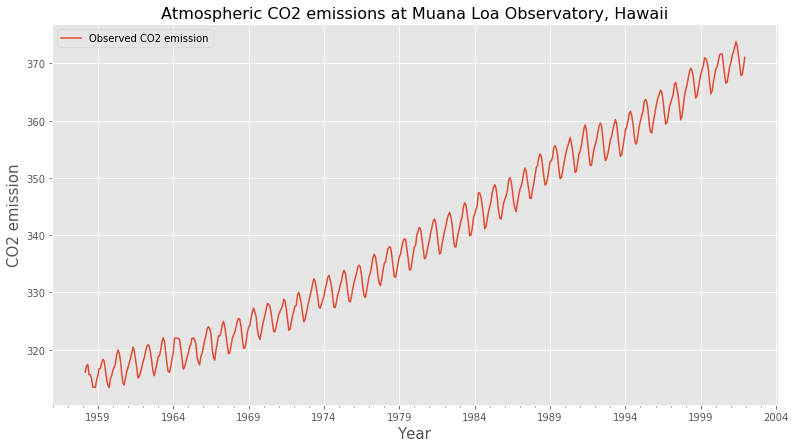

In [25]:
# Create a plot to observe the profile of the CO2 emissions.
ax = df.plot(label = 'Observed CO2 emission',figsize = (13,7))
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('CO2 emission', fontsize = 15)
plt.legend(loc = 'best')
plt.title("Atmospheric CO2 emissions at Muana Loa Observatory, Hawaii", fontsize = 16)
plt.show()

Comments on the plot

It is obvious that the CO2 emission has an overall increasing pattern. Additionally, the profile seems that it also displays a seasonality.

Method to treat the problem

One of the most common methods for time-series forecasting is the AutoregRessive Integrated Moving Average (ARIMA). ARIMA is a model that is used for understanding or forecasting timeseries. The model is characterised by three parameters (p, d, q), and they for seasonality, trend and noise.

p is the auto-regressive part of the model. The p value (not be confused with the probability value),allows to understand the effect of past values into our model. For example if our profile had a continuous increase in the past, most likely it will keep this profile at the present and future.           
                 
d is the integrated part of the model. This includes all the terms in the model that account for differencing that is needed to be applied in the timeseries (i.e., the number past points  that should be subtracted from the present value). Thus, if the profile is almost constand d will have small value.

q is the moving average part of the model. The q value allows to set the error in our model as a linear combination of the past measurements.

In [12]:
# Before we create out ARIMA model, we need to define the values that p,d, and q may have.
p = d = q = range(0, 2)

In [13]:
# Now we can generate all the possible combinations we can have.
pdq = list(itertools.product(p, d, q))

In [14]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Now let's use the generated parameters to create and evaluate ARIMA models based on all possible combinations. The process below is known in machine learning as grid search (i.e., search for the optimal parameters). The task is to get the best parameters for verifying how well the model fits the data, or in the case of times-series how well it can predict future values.

Every ARIMA model will return the Akaike Information Criterion (AIC) value. AIC measures how well a model fits the data based on the model. For example a model that fits very well to the data, if it used a lot of features will be assigned with a higher AIC score, than a model that has the same goodness-of-fit, but needs fewer parameters. Thus, the lowest AIC value is wanted.
 
The code below uses the SARIMAX function to fit the corresponding seasonal ARIMA model.

In our code, the order argument specifies the (p, d, q) parameters, while the seasonal_order, specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. Every time a model is fitted, its AIC score is printed.              


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624044713
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727638644
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.287843181396
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897806896
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.764791287623
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755208342
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327669339
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941066953427
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471682013


/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1087.6320514168794
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4314654791453
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893627904
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.091298832883
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919409
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385496104305
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501757828721
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283760149087
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:478.3296907421498


/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:323.32466545150777
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1371.1872602337867
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1101.8410734303466
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:587.9479710055668
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:302.49490000884066
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:584.4333533192907
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:337.1999049728058
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:433.0863608140669
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5190180882345
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1676.888176736206
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1241.9354335264331
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:624.2602350139374
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:341.28966122629254
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:579.3896922424731
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:370.59205006843075
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:476.0500428105315
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:329.58450034096717
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1372.608588149407
AR

/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:587.0319451364178


/Users/apple/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:399.17194621647275
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:433.5469464510562
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:285.7651791746614
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1324.3111127324569
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1060.9351914444687
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:600.7412683286377
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:312.13296329319087
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:593.6637754767337
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:349.20914638126783
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:440.13758851964735
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:293.7426223189078
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1262.6545542464755
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1052.0636724059336
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:581.3099934602417
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:295.93740590223905
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:576.8647112294245
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:327.90491339966115
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:428.60246330601854

In [16]:
# As mentioned above,by applying a grid search method, we can estimate the set of parameters that 
# produces the best model for our data. Below we can analyse this model in greater detail.

# Fit the best ARIMA model in our dataset.              
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.161      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


If we have a look on the returned summary and focus on the coefficient column, we can see the importance (weight) of each feature and how it affects the data. Our weights have a p-value much lower, or close to 0.05 (5%), thus we can keep all of them in our model.

We should note here, that every time we fit a model, it is important to go through a diagnostics test, for verifying that no model assumption has been violated. A good choice is for this is using plot_diagnostics from which we can investigate any unusual pattern. 

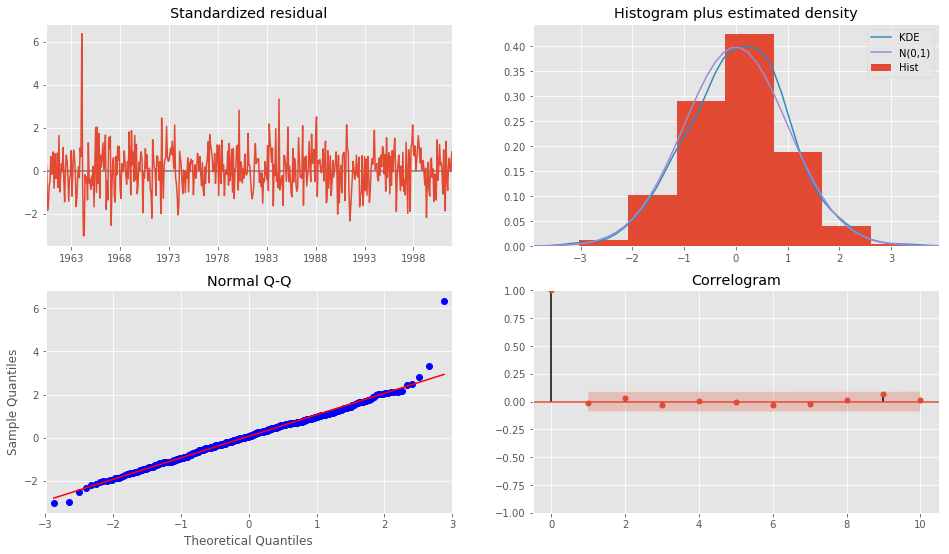

In [17]:
results.plot_diagnostics(figsize=(16, 9))
plt.show()

Comments on plot diagnostics

We need to ensure that the observed residuals in our model are uncorrelated, and normally distributed with zero-mean. If our seasonal ARIMA model does not satisfy these properties, this suggest that the model needs improvement. For our case here, model diagnostics suggest that the model residuals are normally distributed. 

Starting from the top left curve, it is clear that the residuals don't display an obvious seasonality. If we have a look on the top right plot, we see that the KDE profile follows closely a normal distribution. This suggests that the residual are normally distributed. 

Furthermore, by looking at the qq-plot it is clear that the ordered distribution of residuals (blue dots) follow the linear trend from the normal distribution. This is an indication that the residuals are normally distributed. Finally, the autocorrelation plot on the bottom right shows that the observed residuals have low correlation

Based on all the above, we can state that our model produce a satisfactory result. We should mention that eventhough our model looks good we may find better models if we widen the grid search process.


Validating Forecasts

Prior doing any forecasting estimates, it is prefferable to compare our model with actual values. By suing the get_prediction() and conf_int() fucntions we will the values and the associated confidence intervals for forecasts of the time series.

We can choose date that we can the forecastring (i.e., '1996-01-01'). The dynamic = False options, ensures we an one-step ahead forecast is made, which that a forecast at any point is generated by using the history to that point.

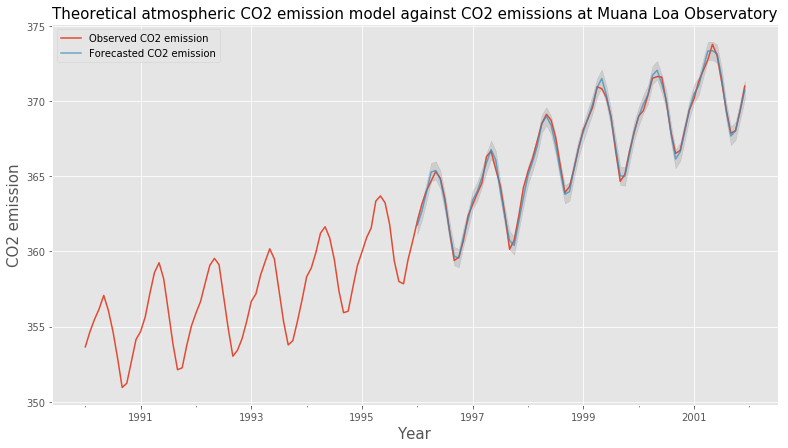

In [40]:
# Compare the theoretical model with the observation
CO2_pred = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic = False)
pred_ci = CO2_pred.conf_int()

ax = df['1990':].plot(label='Observed CO2 emission',figsize = (13,7))
CO2_pred.predicted_mean.plot(ax = ax, label = 'Forecasted CO2 emission', alpha = .7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.1)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('CO2 emission', fontsize = 15)
plt.title("Theoretical atmospheric CO2 emission model against CO2 emissions at Muana Loa Observatory", fontsize = 15)
plt.legend(loc = 'best')
plt.show()

In [28]:
# From the generated plot, it is clear that the predictions match almost perfect the actual result. To be more precise, 
# we should make error estimates too.

df_forecasted = CO2_pred.predicted_mean
df_actual = df['1996-01-01':]

# Compute the mean square error
mse = ((df_forecasted - df_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.09


The mean sqaured error is very low (0.09). If we want to take a better and more realistic representation we should use dynamic forescasts. The difference here is that forecasting is made by using information up to certain point.

In [29]:
# Dynamic predictions plot
CO2_pred_dyn = results.get_prediction(start=pd.to_datetime('1996-01-01'), dynamic = True, full_results = True)
pred_ci_dyn = CO2_pred_dyn.conf_int()

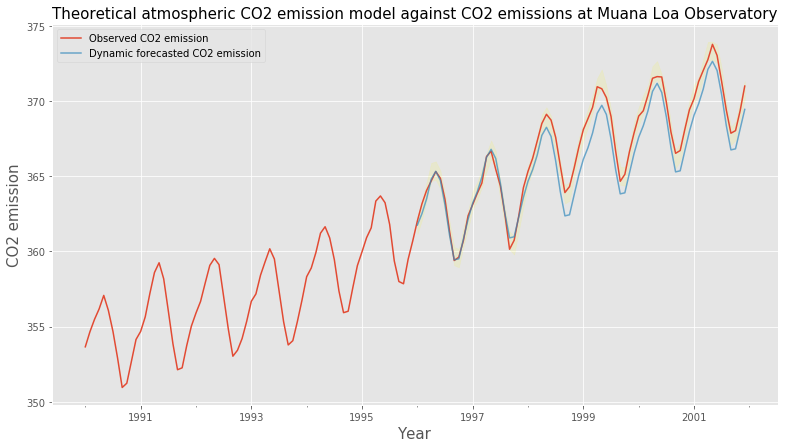

In [38]:
# Create the plot
ax = df['1990':].plot(label='Observed CO2 emission',figsize = (13, 7))
CO2_pred_dyn.predicted_mean.plot(ax = ax, label = 'Dynamic forecasted CO2 emission', alpha = .7)
ax.fill_between(pred_ci_dyn.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'yellow', alpha = 0.1)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('CO2 emission', fontsize = 15)
plt.title("Theoretical atmospheric CO2 emission model against CO2 emissions at Muana Loa Observatory", fontsize = 15)
plt.legend(loc = 'best')
plt.show()

In [32]:
# Make error estimates
df_forecasted_dyn = CO2_pred_dyn.predicted_mean
df_actual_dyn = df['1996-01-01':]

# Compute the mean square error
mse_dyn = ((df_forecasted_dyn - df_actual_dyn) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_dyn, 2)))

The Mean Squared Error of our forecasts is 1.15


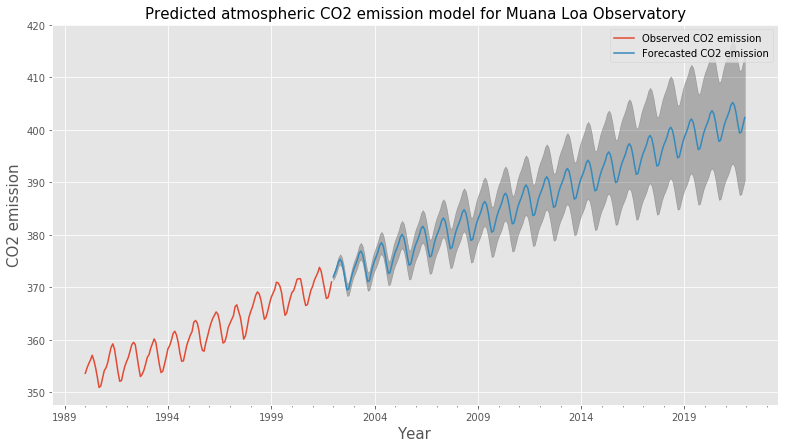

In [43]:
# Produce forecast (future)
pred_uc = results.get_forecast(steps = 240) # 240 months - 20 years

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# Visualising our findings.
ax = df['1990':].plot(label='Observed CO2 emission',figsize = (13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted CO2 emission')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color = 'k', alpha = .25)
ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('CO2 emission', fontsize = 15)
plt.title("Predicted atmospheric CO2 emission model for Muana Loa Observatory", fontsize = 15)
plt.legend(loc = "best")
plt.show()

Final comments

The forecasts and associated confidence intervals can be used to any point in the future we wish to make an estimate. From the model it is clear that the CO2 will keep an increasing profile at steady pace. The main issue is that we move further into the future, it is evident that our models becomes less realistic, as the confidence intervals indicate.